In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:

def create_test_image(size=256):
    """Create a test image with different intensity regions."""
    img = np.zeros((size, size))

    # Create background
    img += 0.3

    # Add shapes
    center = size // 2
    y, x = np.ogrid[-center:size-center, -center:size-center]

    # Add circle
    mask_circle = x*x + y*y <= (size//4)**2
    img[mask_circle] = 0.7

    # Add rectangle
    img[size//4:size//2, size//4:3*size//4] = 0.9

    return img

def add_gaussian_noise(image, variance):
    """Add Gaussian noise with specified variance."""
    noise = np.random.normal(0, np.sqrt(variance), image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 1)

def arithmetic_mean_filter(image, kernel_size):
    """Apply arithmetic mean filter."""
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    return signal.convolve2d(image, kernel, mode='same', boundary='symm')

def geometric_mean_filter(image, kernel_size):
    """Apply geometric mean filter."""
    kernel = np.ones((kernel_size, kernel_size))
    log_image = np.log(image + 1e-10)
    filtered = signal.convolve2d(log_image, kernel, mode='same', boundary='symm')
    filtered = filtered / (kernel_size * kernel_size)
    return np.exp(filtered)

def adaptive_local_filter(image, kernel_size, noise_variance):
    """Apply adaptive local noise reduction filter."""
    # Pad image for window operations
    pad = kernel_size // 2
    padded = np.pad(image, pad, mode='symmetric')
    result = np.zeros_like(image)

    # Calculate local statistics for each pixel
    for i in range(pad, padded.shape[0] - pad):
        for j in range(pad, padded.shape[1] - pad):
            # Extract local window
            window = padded[i-pad:i+pad+1, j-pad:j+pad+1]

            # Calculate local mean and variance
            local_mean = np.mean(window)
            local_var = np.var(window)

            # Apply adaptive filter
            if local_var > 0:
                k = noise_variance / local_var
                result[i-pad, j-pad] = local_mean + (1 - k) * (padded[i,j] - local_mean)
            else:
                result[i-pad, j-pad] = local_mean

    return result



In [3]:
# Create and process images
image_size = 256
kernel_size = 5
noise_variance = 0.01  # Equivalent to variance 1000 for image in [0,255] scale

# Create original and noisy images
original = create_test_image(image_size)
noisy = add_gaussian_noise(original, noise_variance)

# Apply filters
arithmetic = arithmetic_mean_filter(noisy, kernel_size)
geometric = geometric_mean_filter(noisy, kernel_size)
adaptive = adaptive_local_filter(noisy, kernel_size, noise_variance)

# Calculate PSNR values
psnr_noisy = psnr(original, noisy, data_range=1.0)
psnr_arithmetic = psnr(original, arithmetic, data_range=1.0)
psnr_geometric = psnr(original, geometric, data_range=1.0)
psnr_adaptive = psnr(original, adaptive, data_range=1.0)



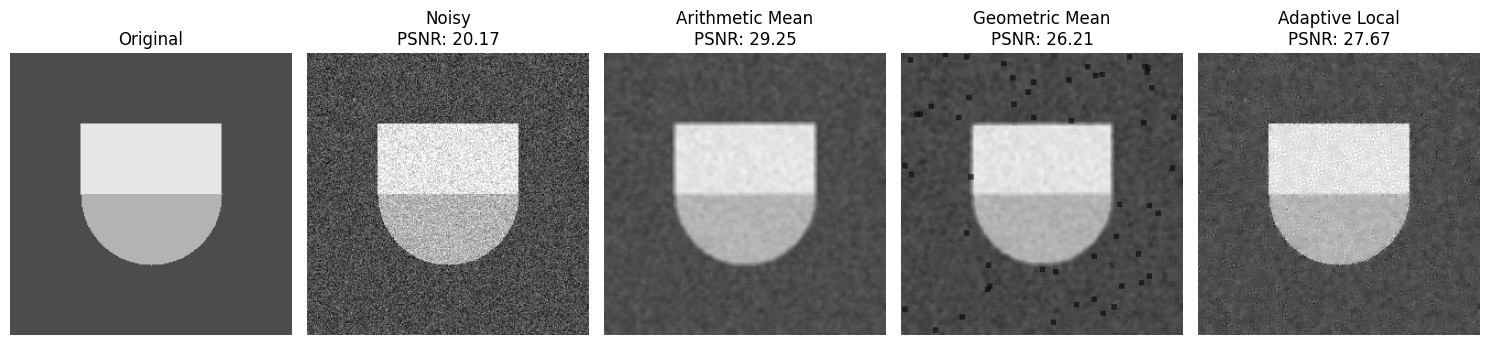


Filter Performance Analysis:
Noisy Image PSNR: 20.17
Arithmetic Mean Filter PSNR: 29.25
Geometric Mean Filter PSNR: 26.21
Adaptive Local Filter PSNR: 27.67


In [4]:
# Visualization
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(151)
plt.imshow(original, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.axis('off')

# Noisy image
plt.subplot(152)
plt.imshow(noisy, cmap='gray', vmin=0, vmax=1)
plt.title(f'Noisy\nPSNR: {psnr_noisy:.2f}')
plt.axis('off')

# Arithmetic mean filter
plt.subplot(153)
plt.imshow(arithmetic, cmap='gray', vmin=0, vmax=1)
plt.title(f'Arithmetic Mean\nPSNR: {psnr_arithmetic:.2f}')
plt.axis('off')

# Geometric mean filter
plt.subplot(154)
plt.imshow(geometric, cmap='gray', vmin=0, vmax=1)
plt.title(f'Geometric Mean\nPSNR: {psnr_geometric:.2f}')
plt.axis('off')

# Adaptive filter
plt.subplot(155)
plt.imshow(adaptive, cmap='gray', vmin=0, vmax=1)
plt.title(f'Adaptive Local\nPSNR: {psnr_adaptive:.2f}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nFilter Performance Analysis:")
print(f"Noisy Image PSNR: {psnr_noisy:.2f}")
print(f"Arithmetic Mean Filter PSNR: {psnr_arithmetic:.2f}")
print(f"Geometric Mean Filter PSNR: {psnr_geometric:.2f}")
print(f"Adaptive Local Filter PSNR: {psnr_adaptive:.2f}")